# IMPORT LIBRARIES

In [2]:
#http://127.0.0.1:8888/lab?token=2db665e21c0673c2e04d08a637168a7be000ea2ace4da3bd

In [3]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for GPU")
    except RuntimeError as e:
        print("Error enabling memory growth:", e)
else:
    print("No GPUs detected.")

# Check if GPU is available and being used
if tf.test.is_gpu_available():
    print("TensorFlow is using the GPU.")
else:
    print("TensorFlow is using the CPU.")


Memory growth enabled for GPU
TensorFlow is using the GPU.


2024-12-13 19:31:14.548139: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-13 19:31:14.548275: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-13 19:31:14.548321: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-13 19:31:14.548732: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-13 19:31:14.548749: I tensorflow/core/common_runtime/gpu/gpu

In [4]:
!pip install -U scipy

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [5]:
import numpy as np 
import pandas as pd 
import os
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
from skimage import img_as_float
from skimage import exposure
from skimage.restoration import denoise_tv_chambolle, denoise_bilateral, denoise_wavelet, estimate_sigma
from skimage.filters import threshold_multiotsu,threshold_otsu
from skimage.morphology import erosion, dilation, opening, closing,disk
from skimage.measure import label, regionprops,find_contours
from skimage.morphology import erosion, dilation, opening, closing,disk
import cv2

In [8]:
from tensorflow.keras.applications import MobileNet,VGG19,EfficientNetV2S
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten,BatchNormalization,Input,Conv2D,MaxPooling2D,concatenate,Conv2DTranspose
from keras.models import Sequential


# LOAD DATA

In [9]:
!ls

'=24.4'					    media
 NGC-DL-CONTAINER-LICENSE		    mnt
 bin					    nih_data
 boot					    opt
 cuda-keyring_1.0-1_all.deb		    proc
 dev					    root
 entrypoint.sh				    run
 etc					    run_jupyter.sh
 home					    sbin
 install_packages.sh			    srv
 lib					    sys
 lib32					    tmp
 lib64					    usr
 libnvinfer8_8.6.1.6-1+cuda12.0_amd64.deb   var
 libx32


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [10]:
all_xray_df = pd.read_csv('nih_data/nih-chest-xrays/data/versions/3/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('nih_data','nih-chest-xrays', 'data','versions','3','images*', '*', '*.png'))}

all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get) #get image path
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,nih_data/nih-chest-xrays/data/versions/3/image...
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,nih_data/nih-chest-xrays/data/versions/3/image...
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,nih_data/nih-chest-xrays/data/versions/3/image...
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,nih_data/nih-chest-xrays/data/versions/3/image...
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,nih_data/nih-chest-xrays/data/versions/3/image...


# VISUALIZATION

In [11]:
# 1 image can have multiple class
label_counts = all_xray_df['Finding Labels'].value_counts()
label_counts

Finding Labels
No Finding                                                         60361
Infiltration                                                        9547
Atelectasis                                                         4215
Effusion                                                            3955
Nodule                                                              2705
                                                                   ...  
Atelectasis|Consolidation|Edema|Effusion|Infiltration|Pneumonia        1
Atelectasis|Consolidation|Effusion|Emphysema|Mass|Pneumothorax         1
Cardiomegaly|Effusion|Pleural_Thickening|Pneumothorax                  1
Edema|Infiltration|Pneumothorax                                        1
Atelectasis|Consolidation|Mass|Pleural_Thickening|Pneumothorax         1
Name: count, Length: 836, dtype: int64

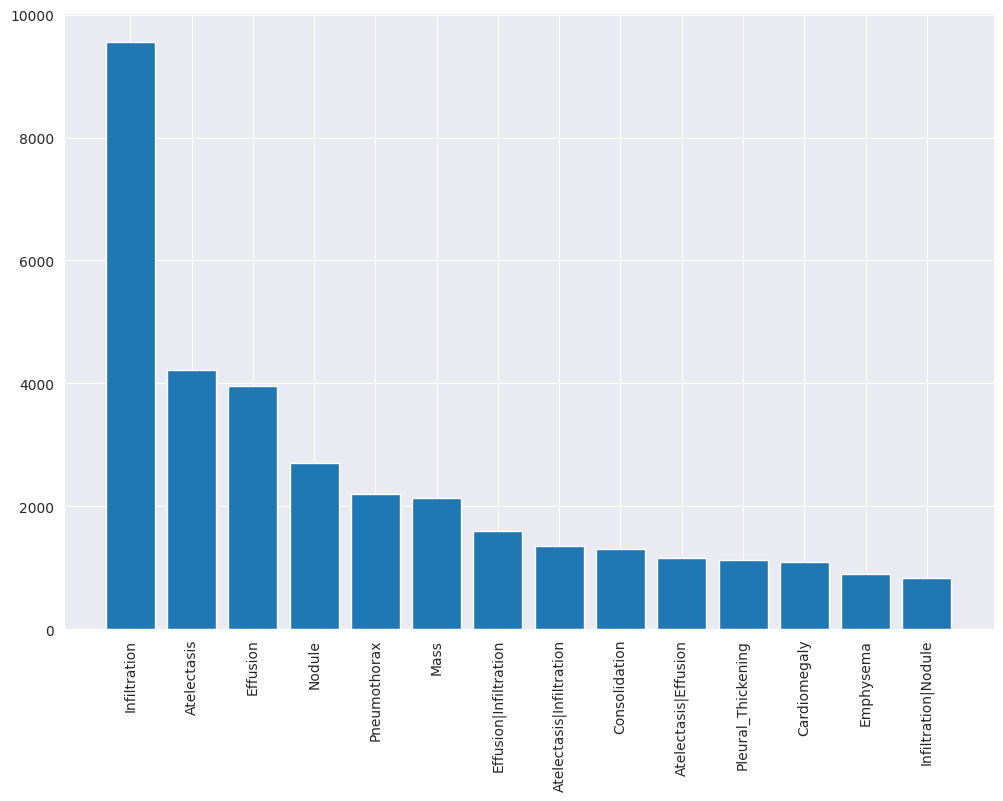

In [12]:
# Top 15 class
label_counts = all_xray_df['Finding Labels'].value_counts()[1:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

=> imbalance dataset

# DATA PROCESSING

## One-hot

In [13]:
all_labels = ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening', 
'Cardiomegaly', 'Nodule', 'Mass', 'Hernia'] # taken from paper

# make one-hot
for lb in all_labels:
    all_xray_df[lb] = all_xray_df['Finding Labels'].map(lambda result: 1.0 if lb in result else 0)
all_xray_df.head(20) 


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Edema,Emphysema,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,00000003_001.png,Hernia,1,3,74,F,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6,00000003_002.png,Hernia,2,3,75,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7,00000003_003.png,Hernia|Infiltration,3,3,76,F,PA,2698,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8,00000003_004.png,Hernia,4,3,77,F,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9,00000003_005.png,Hernia,5,3,78,F,PA,2686,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Train test split

In [14]:
# lấy 40000 sample có trọng số
sample_weights = all_xray_df['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()
all_xray_df = all_xray_df.sample(40000, weights=sample_weights)


In [15]:
train_df, valid_df = train_test_split(all_xray_df, 
                                   test_size = 0.2, 
                                   stratify = all_xray_df['Finding Labels'].map(lambda x: x[:4]))
print('train', train_df.shape[0], 'validation', valid_df.shape[0])

train 32000 validation 8000


In [16]:
train_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Edema,Emphysema,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia
93555,00023478_000.png,No Finding,0,23478,38,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100330,00026586_006.png,Pneumothorax,6,26586,37,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93360,00023325_015.png,Effusion,15,23325,81,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
57500,00014253_042.png,Atelectasis|Effusion,42,14253,60,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
36781,00009689_017.png,No Finding,17,9689,55,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Data Generator

In [17]:
IMAGE_SIZE = 128

In [18]:
strategy = tf.distribute.MirroredStrategy()
print('DEVICES AVAILABLE: {}'.format(strategy.num_replicas_in_sync))

DEVICES AVAILABLE: 1


2024-12-13 19:31:36.991946: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-13 19:31:36.992221: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-13 19:31:36.992293: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-13 19:31:36.993413: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-13 19:31:36.993437: I tensorflow/core/common_runtime/gpu/gpu

In [19]:
AUTOTUNE = tf.data.AUTOTUNE

BATCH_SIZE_PER_REPLICA = 32

#We obtain the BATCH_SIZE dividing by the number of devices. 
BATCH_SIZE = BATCH_SIZE_PER_REPLICA*strategy.num_replicas_in_sync


In [20]:
core_idg = ImageDataGenerator(horizontal_flip=True,
                             )

In [21]:
print(train_df.columns)
if 'path' in train_df.columns:
    print("'path' column exists in train_df")
else:
    print("'path' column does not exist in train_df")


Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11', 'path',
       'Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema',
       'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
       'Cardiomegaly', 'Nodule', 'Mass', 'Hernia'],
      dtype='object')
'path' column exists in train_df


In [22]:
train_generator = core_idg.flow_from_dataframe(dataframe=train_df,
                                        directory=None,
                                        x_col = 'path',
                                        y_col = all_labels,
                                        class_mode = 'raw',
#                                         classes = all_labels,
                                        target_size = (IMAGE_SIZE,IMAGE_SIZE),
                                        color_mode = 'grayscale',
                                        batch_size = BATCH_SIZE,
                                        shuffle = True)
valid_generator = core_idg.flow_from_dataframe(dataframe=valid_df,
                                        directory=None,
                                        x_col = 'path',
                                        y_col = all_labels,
                                        class_mode = 'raw',
#                                         classes = all_labels,
                                        target_size = (IMAGE_SIZE,IMAGE_SIZE),
                                        color_mode = 'grayscale',
                                        batch_size = 256)

Found 32000 validated image filenames.
Found 8000 validated image filenames.


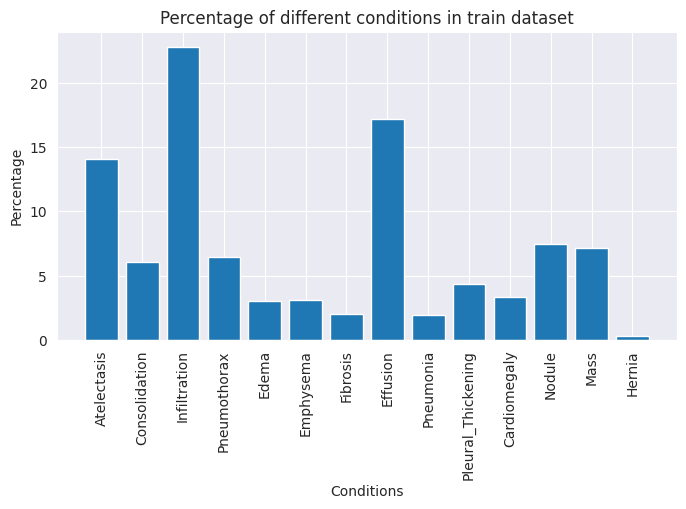

In [23]:
plt.figure(figsize=(8,4))
plt.xticks(rotation = 90)
plt.bar(all_labels, train_generator.labels.sum(axis = 0)/train_generator.n * 100)
plt.title('Percentage of different conditions in train dataset')
plt.xlabel('Conditions')
plt.ylabel('Percentage')
plt.show()


## Convert to TF dataset

In [24]:
raw_train_data = tf.data.Dataset.from_generator(
                lambda: train_generator,
                output_types = (tf.float32, tf.float32), 
                output_shapes = ([None,IMAGE_SIZE,IMAGE_SIZE,1], [None,len(all_labels)]))


raw_valid_data = tf.data.Dataset.from_generator(
                lambda: valid_generator,
                output_types=(tf.float32, tf.float32), 
                output_shapes=([None,IMAGE_SIZE,IMAGE_SIZE,1], [None,len(all_labels)]))

In [25]:
raw_train_data

<_FlatMapDataset element_spec=(TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 14), dtype=tf.float32, name=None))>

In [26]:
one_batch_samples = next(iter(raw_train_data))

In [27]:
image_samples, label_samples = one_batch_samples

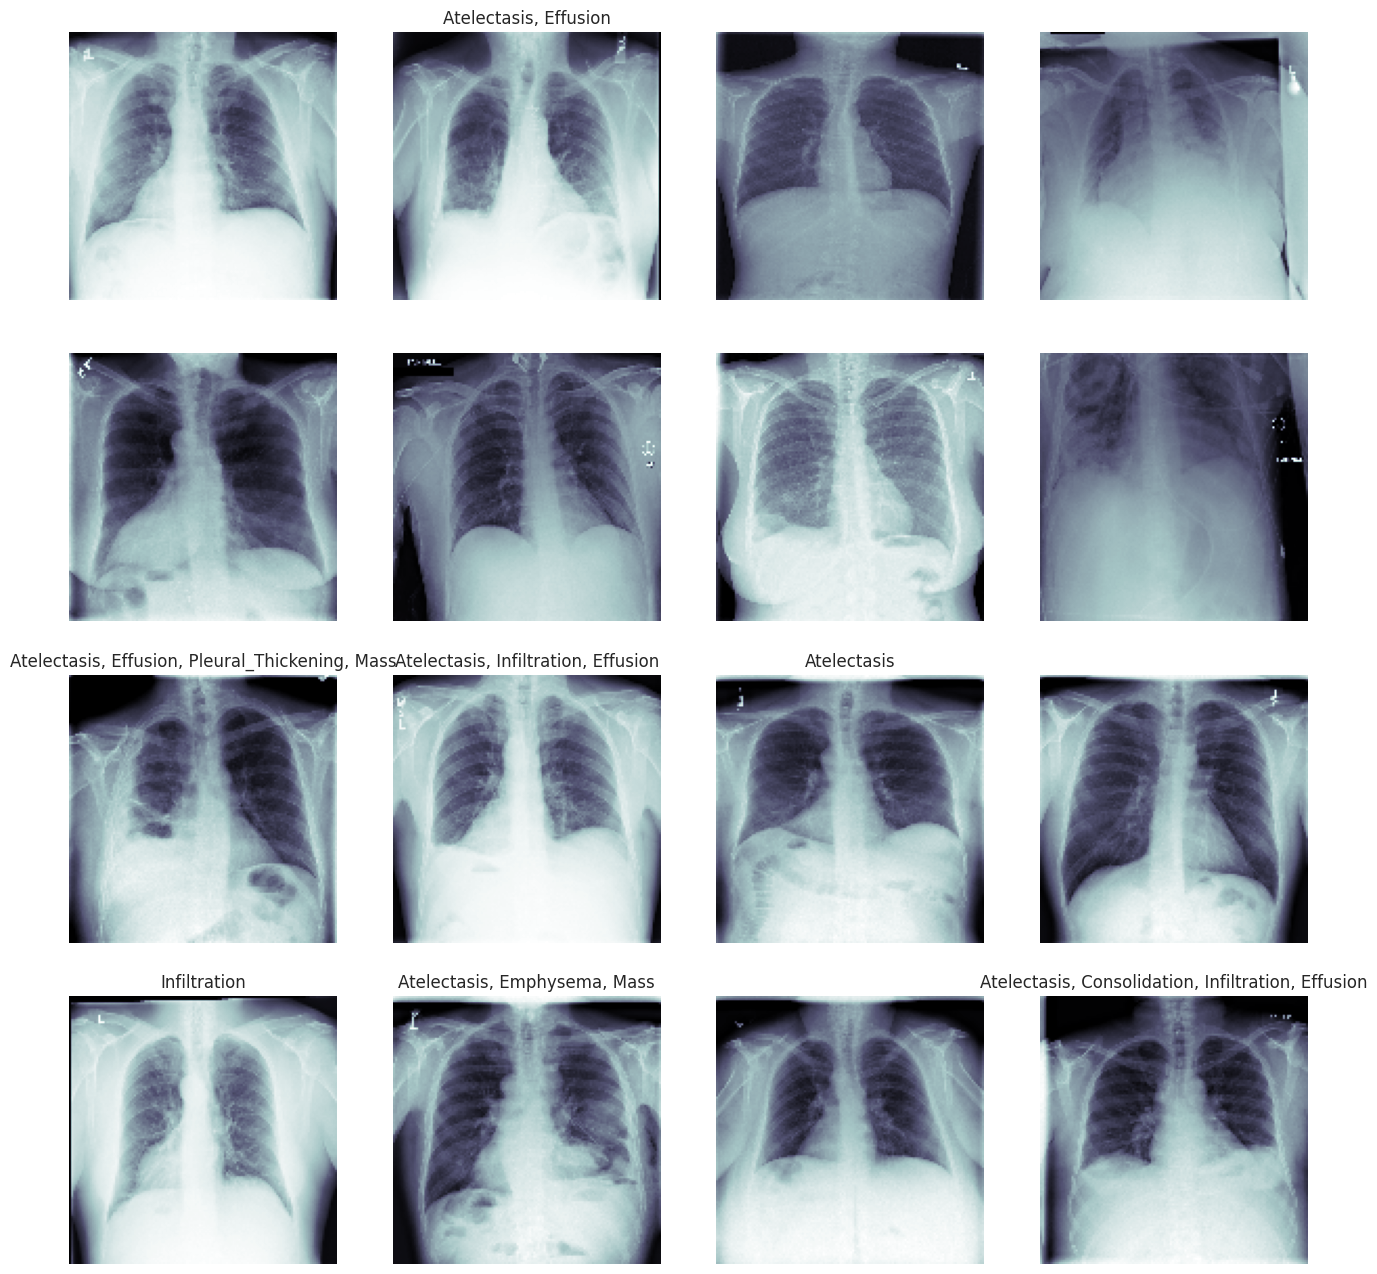

In [28]:
fig, axes = plt.subplots(4, 4, figsize = (16, 16))
for (img, lb, ax) in zip(image_samples, label_samples, axes.flatten()):
    ax.imshow(img, cmap = 'bone')
    img_lab_name = np.array(all_labels)[lb.numpy() == 1.0]
    
    ax.set_title(', '.join(img_lab_name))
    ax.axis('off')

## RESCALE

In [29]:
normalization_layer = tf.keras.layers.Rescaling(1./255)


In [53]:
scale_train_data = raw_train_data.map(lambda x,y: (normalization_layer(x),y),num_parallel_calls = AUTOTUNE)
scale_valid_data = raw_valid_data.map(lambda x,y: (normalization_layer(x),y),num_parallel_calls = AUTOTUNE)

## BACKGROUND REMOVAL

In [54]:
def background_rm(image):
    
    img_list = []
    for i in range(image.shape[0]):
        try:
            img = image[i]

            sumOfCols = np.sum(img, axis=0)
            sumOfRows = np.sum(img, axis=1)

            for i in range(len(sumOfCols)):
                if sumOfCols[i] > 0:
                    x1 = i
                    break

            for i in range(len(sumOfCols)-1,-1,-1):
                if sumOfCols[i] > 0:
                    x2 = i
                    break

            for i in range(len(sumOfRows)):
                if sumOfRows[i] > 0:
                    y1 = i
                    break

            for i in range(len(sumOfRows)-1,-1,-1):
                if sumOfRows[i] > 0:
                    y2 = i
                    break

            roi = img[y1:y2,x1:x2]
            roi = tf.keras.layers.Resizing(IMAGE_SIZE,IMAGE_SIZE) (roi)
            img_list.append(roi)
        except:
            img_list.append(img)

    return tf.convert_to_tensor(tf.stack(img_list))


In [55]:
def background_rm_tf(image,label):
    im_shape = image.shape
    [image,] = tf.py_function(background_rm, [image], [tf.float32])
    image.set_shape(im_shape)
    return image, label


In [56]:
rm_background_train_data = scale_train_data.map(background_rm_tf,num_parallel_calls = AUTOTUNE)
rm_background_valid_data = scale_valid_data.map(background_rm_tf,num_parallel_calls = AUTOTUNE)

## REMOVE NOISE

In [57]:
def denoise(image):
    return denoise_tv_chambolle(img_as_float(image), weight=0.01)


In [58]:
def denoise_tf(image,label):
    im_shape = image.shape
    [image,] = tf.py_function(denoise, [image], [tf.float32])
    image.set_shape(im_shape)
    return image, label


In [59]:
rm_noise_train_data = rm_background_train_data.map(denoise_tf,num_parallel_calls = AUTOTUNE)
rm_noise_valid_data = rm_background_valid_data.map(denoise_tf,num_parallel_calls = AUTOTUNE)

## REMOVE THE DIAPHRAGM REGION

In [60]:
def rmDiapgRegion(image):
    img = img_as_float(image)
    img = np.copy(img)
    # get Diaphragm Region
    
    brightest = img.max()
    darkest = img.min()
#     print(brightest)
    T = darkest + 0.94 * (brightest - darkest)
    binary = img > T

    closed = closing(binary) 
    dilate = dilation(closed)

    # get high density region
    l = label(dilate)
    out = (l==np.bincount(l.ravel())[1:].argmax()+1).astype(np.int64)

    # smoothing region
#     opened = closing(out)
    img[out.astype(np.float32) == 1.0] = 0
        
    return img


In [61]:
def rmDiapgRegion_tf(image,label):
    im_shape = image.shape
    [image,] = tf.py_function(rmDiapgRegion, [image], [tf.float32])
    image.set_shape(im_shape)
    return image, label


In [62]:
rm_diapg_train_data = rm_noise_train_data.map(rmDiapgRegion_tf,num_parallel_calls =AUTOTUNE)
rm_diapg_valid_data = rm_noise_valid_data.map(rmDiapgRegion_tf,num_parallel_calls =AUTOTUNE)

In [63]:
rm_diapg_train_data

<_ParallelMapDataset element_spec=(TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 14), dtype=tf.float32, name=None))>

2024-12-13 19:37:59.778630: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


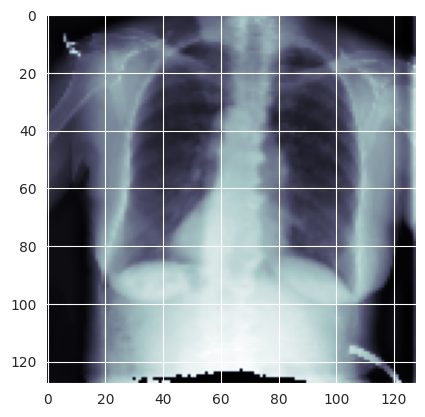

In [64]:
for image,l in rm_diapg_train_data.take(1):
    plt.imshow(image[3],cmap = 'bone')

## CONTRAST ENRICHMENT


In [65]:
def contrast_enrich(image):
    return exposure.equalize_adapthist(img_as_float(image),clip_limit = 0.02)
        

In [66]:
def contrast_enrich_tf(image,label):
    im_shape = image.shape
    [image,] = tf.py_function(contrast_enrich, [image,], [tf.float32])
    image.set_shape(im_shape)
    return image, label


In [67]:
enhance_contrast_train_data = rm_diapg_train_data.map(contrast_enrich_tf, num_parallel_calls = AUTOTUNE)
enhance_contrast_valid_data = rm_diapg_valid_data.map(contrast_enrich_tf, num_parallel_calls = AUTOTUNE)


2024-12-13 19:38:18.946835: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


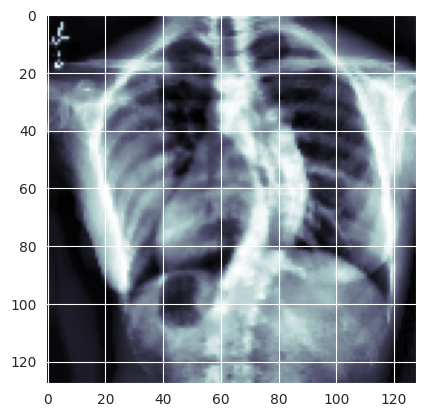

In [68]:
# input image
for image,l in enhance_contrast_train_data.take(1):
    plt.imshow(image[1],cmap = 'bone')

## LUNG SEGMENTATION

A segmentation-based cropped. This function will encourage model to focus on the lungs

In [69]:
inputs = Input((IMAGE_SIZE,IMAGE_SIZE,1))
input_resize = tf.keras.layers.Resizing(512,512, name = 'resize_input') (inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_resize)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

model = tf.keras.Model(inputs=[inputs], outputs=[conv10])

In [70]:
model.load_weights("nih_data/unet-lung-segmentation-weights-for-chest-x-rays/cxr_reg_weights.best.hdf5")

In [71]:
def lung_segment(image):
    pred = model.predict(image,verbose = 0) > 0.4
    pred = pred.astype(np.int32) # 512,512
    img_list = []
    
    for i in range(image.shape[0]):
        l = label(pred[i])
        z = np.argpartition(np.bincount(l.ravel())[1:],-2)

        out_1 = (l== z[-2] +1).astype(int)
        out_2 = (l== z[-1] +1).astype(int)
        combine = out_1 + out_2
        combine = tf.squeeze(combine)    

        minc_local, maxc_local = 1000,0
        
        label_image = label(combine)
        regions = regionprops(label_image)

        for region in regions:
            minr, minc, maxr, maxc = region.bbox
            if minc_local > minc:
                minc_local = minc
            if maxc_local < maxc:
                maxc_local = maxc

#         if maxc_local - minc_local <= 200 or maxc_local - minc_local >= 300:
#             img_list.append(image[i])
#             continue
        img = tf.keras.layers.Resizing(512,512) (image[i])
        if minc_local - 20 >=0:
            minc_local -= 20
        if maxc_local + 20 <= img.shape[0]:
            maxc_local += 20
        z = img[:,minc_local:maxc_local]
        z = tf.keras.layers.Resizing(IMAGE_SIZE,IMAGE_SIZE,interpolation = "area") (z)
        img_list.append(z)

    return tf.convert_to_tensor(tf.stack(img_list))

In [72]:
def lung_segment_tf(image,label):
    im_shape = image.shape
    [image,] = tf.py_function(lung_segment, [image], [tf.float32])
    image.set_shape(im_shape)
    return image, label


In [73]:
lung_segment_train_data = enhance_contrast_train_data.map(lung_segment_tf, num_parallel_calls = AUTOTUNE)
lung_segment_valid_data = enhance_contrast_valid_data.map(lung_segment_tf, num_parallel_calls = AUTOTUNE)


In [74]:
def plot_lung_segment_img(image_sample):
    test_img = tf.expand_dims(image_sample,0)
    test_img /= 255.
    test_img = contrast_enrich(test_img)
    test_img = lung_segment(test_img)[0] # it return batchsize,_,_
    
    fig,axes = plt.subplots(1,2,figsize = (15,15))
    axes[0].imshow(image_sample,cmap = 'bone')
    axes[0].set_title("Original Image")
    
    axes[1].imshow(test_img,cmap = 'bone')
    axes[1].set_title("Segmentation-based cropped")


In [75]:
plot_lung_segment_img(image_samples[8])

ValueError: Exception encountered when calling Resizing.call().

[1mInvalid value for argument `interpolation`. Expected of one ('bilinear', 'nearest', 'lanczos3', 'lanczos5', 'bicubic'). Received: interpolation=area[0m

Arguments received by Resizing.call():
  • inputs=tf.Tensor(shape=(512, 400, 1), dtype=float32)

# MODEL

In [76]:
train_data = scale_train_data.map(lambda x,y: (tf.image.grayscale_to_rgb(x),y)).cache().prefetch(buffer_size = AUTOTUNE)
valid_data = scale_valid_data.map(lambda x,y: (tf.image.grayscale_to_rgb(x),y)).cache().prefetch(buffer_size = AUTOTUNE)

In [77]:
test_X, test_Y = next(core_idg.flow_from_dataframe(dataframe=valid_df,
                                        directory=None,
                                        x_col = 'path',
                                        y_col = all_labels,
                                        class_mode = 'raw',
#                                         classes = all_labels,
                                        target_size = (IMAGE_SIZE,IMAGE_SIZE),
                                        color_mode = 'grayscale',
                                        batch_size = 1024))


Found 8000 validated image filenames.


In [78]:
test_X_normal = tf.keras.layers.Rescaling(1./255) (test_X)
test_X_normal = tf.image.grayscale_to_rgb(tf.convert_to_tensor(test_X_normal))

In [79]:
test_X_process = test_X.copy()

test_X_process = background_rm(test_X_process)
test_X_process = tf.keras.layers.Rescaling(1./255) (test_X_process)
test_X_process = denoise(test_X_process)
test_X = rmDiapgRegion(test_X)
test_X_process = contrast_enrich(test_X_process)
# test_X = lung_segment(test_X) #use this will degrade performance
test_X_process = tf.image.grayscale_to_rgb(tf.convert_to_tensor(test_X_process))

## DENSE121

In [80]:
input = tf.keras.layers.Input([IMAGE_SIZE, IMAGE_SIZE, 3], dtype = tf.float32)

dense121 = tf.keras.applications.DenseNet121(include_top=False,weights="imagenet",pooling='avg')
dense121 = dense121(input,)

output = Dense(len(all_labels), activation = 'sigmoid') (dense121)

dense121_model = tf.keras.Model(inputs=[input], outputs=[output])
dense121_model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 1024)           │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 14)             │        14,350 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,051,854 (26.90 MB)

 Trainable params: 6,968,206 (26.58 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [81]:
dense121_model.compile(optimizer = tf.keras.optimizers.Adam(0.0001), loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', tf.keras.metrics.AUC()])

In [82]:
steps_per_epoch = train_df.shape[0]  // BATCH_SIZE
steps_per_epoch

1000

In [83]:
dense121_model.load_weights("nih_data/vgg19h5/dense121_normal.h5")

In [84]:
dense121_model.fit(train_data, 
            steps_per_epoch = 750,
#           validation_data = valid_data, 
            epochs = 1, 
            verbose = 1,
          )

I0000 00:00:1734119008.664729     390 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_slice_fusion', 16 bytes spill stores, 16 bytes spill loads



750/750 ━━━━━━━━━━━━━━━━━━━━ 805s 862ms/step - auc: 0.7791 - binary_accuracy: 0.9296 - loss: 0.2187


2024-12-13 19:54:15.469791: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [85]:
dense121_model.save_weights("dense121_normal.weights.h5")

### NORMAL

In [86]:
y_pred_dense121_normal = dense121_model.predict(test_X_normal)
y_pred_dense121_normal[:5]


32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step


array([[0.13534702, 0.05397256, 0.21429683, 0.10213497, 0.02666675,
        0.0652099 , 0.02216531, 0.11795255, 0.0229995 , 0.04719198,
        0.04522789, 0.07330798, 0.07923128, 0.00250881],
       [0.2055538 , 0.05624613, 0.2193285 , 0.0992724 , 0.02136035,
        0.04266302, 0.02101254, 0.1460559 , 0.02015967, 0.04148053,
        0.04767207, 0.08372681, 0.09558336, 0.00328312],
       [0.15591627, 0.08920402, 0.3494931 , 0.12569678, 0.05380267,
        0.06965066, 0.01722466, 0.17938359, 0.03455042, 0.0472003 ,
        0.0572754 , 0.0735488 , 0.08664739, 0.00226943],
       [0.20508291, 0.1253597 , 0.38369587, 0.05108808, 0.08589084,
        0.03388544, 0.0066649 , 0.23199312, 0.03425749, 0.02811695,
        0.04692589, 0.04714105, 0.05609728, 0.00119678],
       [0.19887605, 0.17867239, 0.50082725, 0.060114  , 0.09387448,
        0.02915076, 0.0066246 , 0.40857756, 0.04147036, 0.04074937,
        0.05895863, 0.05556086, 0.06759895, 0.00150378]], dtype=float32)

0.6603059047855775


Text(0, 0.5, 'True Positive Rate')

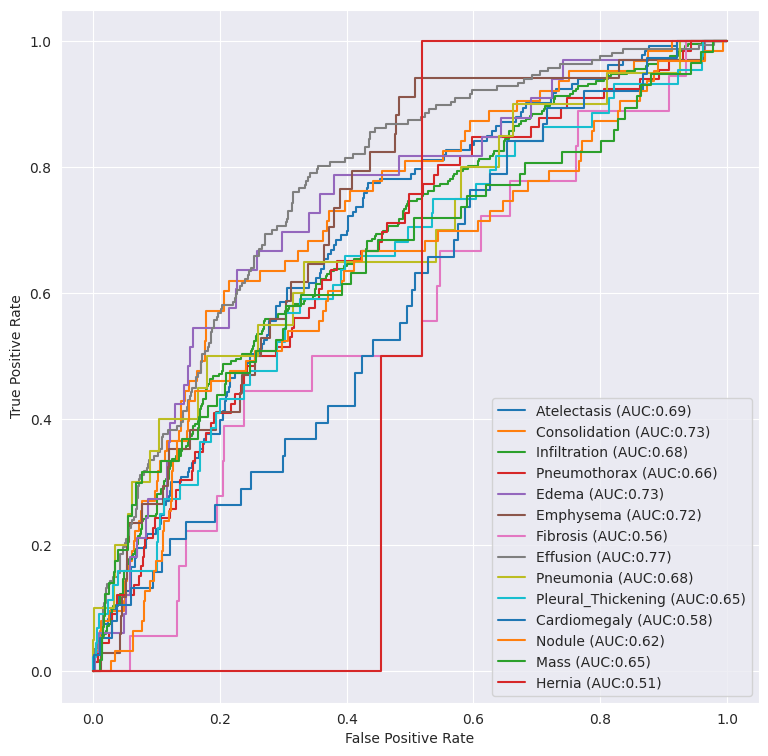

In [87]:
from sklearn.metrics import roc_curve, auc,f1_score
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
mean_auc_dense121_normal = 0
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), y_pred_dense121_normal[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    mean_auc_dense121_normal += auc(fpr, tpr)

mean_auc_dense121_normal /= 14
print(mean_auc_dense121_normal)
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')


### PREPROCESS

In [88]:
dense121_model.load_weights("nih_data/vgg19h5/dense121_3.h5")

In [89]:
y_pred_dense121_preprocess = dense121_model.predict(test_X_process)
y_pred_dense121_preprocess[:5]


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


array([[0.2048484 , 0.10621146, 0.22721687, 0.03875894, 0.04028631,
        0.01861091, 0.01261865, 0.72657037, 0.0233302 , 0.11975729,
        0.02173261, 0.06703368, 0.13113469, 0.00289848],
       [0.04770621, 0.00999941, 0.1268336 , 0.00398926, 0.00196377,
        0.00309113, 0.00807358, 0.02295449, 0.00635867, 0.01722419,
        0.01099476, 0.03200584, 0.02059535, 0.00264612],
       [0.16524038, 0.17458336, 0.38535982, 0.12377629, 0.02456913,
        0.03562809, 0.00278123, 0.48755148, 0.02004668, 0.0694268 ,
        0.01345667, 0.06088399, 0.13586189, 0.00098224],
       [0.08714852, 0.03088919, 0.19191952, 0.00247069, 0.06993331,
        0.00300943, 0.00152762, 0.02626286, 0.01300374, 0.0051415 ,
        0.00924531, 0.09698356, 0.05169096, 0.00086683],
       [0.31505027, 0.20095585, 0.43780354, 0.01505922, 0.09526655,
        0.00737916, 0.002688  , 0.53259385, 0.04420262, 0.02582209,
        0.29855758, 0.02822427, 0.02115114, 0.00102324]], dtype=float32)

0.7760172128127859


Text(0, 0.5, 'True Positive Rate')

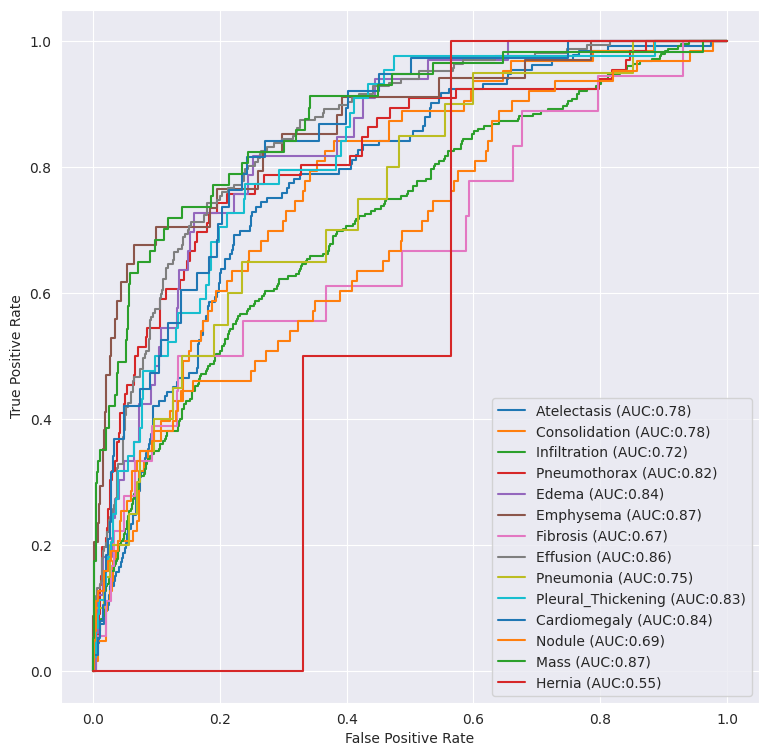

In [90]:
from sklearn.metrics import roc_curve, auc,f1_score
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
mean_auc_dense121_preprocess = 0
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), y_pred_dense121_preprocess[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    mean_auc_dense121_preprocess += auc(fpr, tpr)

mean_auc_dense121_preprocess /= 14
print(mean_auc_dense121_preprocess)
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')


## VGG19

In [91]:
input = tf.keras.layers.Input([IMAGE_SIZE, IMAGE_SIZE, 3], dtype = tf.float32)
processed_input = tf.keras.applications.vgg19.preprocess_input(input)

vgg19 = VGG19(include_top = False,weights = 'imagenet') 
vgg19 = vgg19(input)

normal = BatchNormalization() (vgg19)
flatten = GlobalAveragePooling2D() (normal)

dense1 = Dense(256,activation = 'relu') (flatten)

output = Dense(len(all_labels), activation = 'sigmoid') (dense1)

vgg19_model = tf.keras.Model(inputs=[input], outputs=[output])
vgg19_model.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 23s 0us/step


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 4, 4, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 4, 4, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 14)             │         3,598 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,161,358 (76.91 MB)

 Trainable params: 20,160,334 (76.91 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [92]:
# vgg19_model.load_weights("nih_data/vgg19h5/vgg19_process_lung_2.h5")

In [93]:
vgg19_model.compile(optimizer = tf.keras.optimizers.Adam(0.0001), loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', tf.keras.metrics.AUC()])

In [94]:
steps_per_epoch = train_df.shape[0]  // BATCH_SIZE
steps_per_epoch

1000

In [95]:
# vgg19_model.fit(train_data, 
#             steps_per_epoch = steps_per_epoch,
# #           validation_data = valid_data, 
#             epochs = 1, 
#             verbose = 1,
#           )

### NORMAL

In [96]:
vgg19_model.load_weights("nih_data/weights/vgg19_no2.h5")

In [97]:
y_pred_vgg19_normal = vgg19_model.predict(test_X_normal)
y_pred_vgg19_normal[:5]

32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 97ms/step


array([[5.8544643e-02, 1.5314363e-02, 2.2237520e-01, 6.9238365e-02,
        1.5266245e-02, 2.9041477e-02, 1.1508776e-03, 8.9477211e-02,
        5.2724956e-03, 2.9685045e-02, 5.3343903e-03, 2.2413637e-02,
        2.2784133e-02, 3.6161618e-05],
       [6.7364573e-02, 2.0334741e-02, 2.3225693e-01, 9.1252230e-02,
        1.6863443e-02, 3.9821342e-02, 2.8737206e-03, 1.1389370e-01,
        7.0838840e-03, 4.3719850e-02, 8.0766203e-03, 3.5110500e-02,
        3.6943126e-02, 1.1571492e-04],
       [7.2423153e-02, 3.7660524e-02, 3.0158997e-01, 6.5977588e-02,
        3.7053369e-02, 2.4103405e-02, 1.3054481e-03, 1.5200274e-01,
        9.5366221e-03, 4.1650664e-02, 1.4614268e-02, 2.3780482e-02,
        3.0344866e-02, 4.5318320e-05],
       [7.6098830e-02, 2.5969120e-02, 2.6780924e-01, 7.4254818e-02,
        2.5228614e-02, 3.0086441e-02, 1.7643363e-03, 1.3213880e-01,
        8.1030829e-03, 3.7982453e-02, 1.0433309e-02, 2.7768351e-02,
        3.0374672e-02, 7.1726288e-05],
       [9.7052447e-02, 4.702

0.5742752722675103


Text(0, 0.5, 'True Positive Rate')

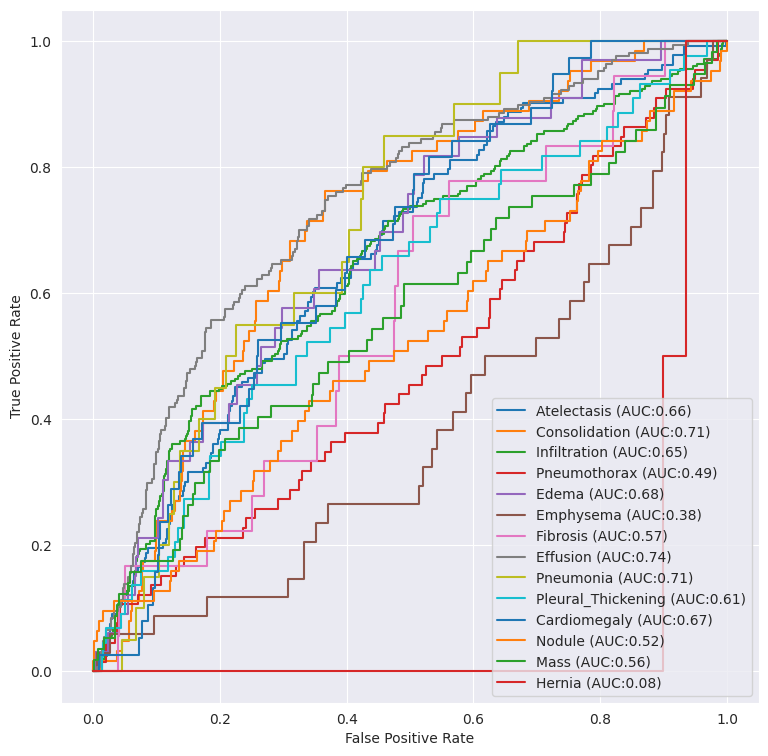

In [98]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
mean_auc_vgg19_normal = 0
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), y_pred_vgg19_normal[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    mean_auc_vgg19_normal += auc(fpr, tpr)
mean_auc_vgg19_normal /= 14
print(mean_auc_vgg19_normal)
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')


### PREPROCESS

In [99]:
vgg19_model.load_weights("nih_data/vgg19h5/vgg19.h5")

In [100]:
y_pred_vgg19_process = vgg19_model.predict(test_X_process)
y_pred_vgg19_process[:5]

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step


array([[3.0620280e-03, 4.0041460e-03, 1.7100292e-01, 2.4739702e-03,
        2.0726856e-04, 4.1760546e-03, 1.4247688e-03, 3.2775823e-03,
        2.2998564e-03, 1.4698020e-01, 6.2993512e-04, 5.5944592e-02,
        2.0432469e-02, 2.2436001e-03],
       [3.9189351e-03, 4.7659897e-03, 1.8209191e-01, 3.0406211e-03,
        2.6845877e-04, 4.8236013e-03, 1.6831557e-03, 4.2506699e-03,
        2.9147964e-03, 1.6275351e-01, 8.0469029e-04, 6.0000367e-02,
        2.2307906e-02, 2.7874268e-03],
       [2.8944146e-02, 3.1261668e-02, 2.7547404e-01, 1.9496320e-02,
        4.4998769e-03, 2.1242291e-02, 6.5271170e-03, 2.8707113e-02,
        1.5186689e-02, 2.0306231e-01, 8.9215934e-03, 9.6155122e-02,
        5.8732077e-02, 9.9521028e-03],
       [2.8982824e-03, 3.4571327e-03, 1.6247845e-01, 2.1146284e-03,
        1.6881542e-04, 3.6484769e-03, 1.3848130e-03, 3.0509850e-03,
        2.0593570e-03, 1.4755672e-01, 5.5338041e-04, 5.5584382e-02,
        1.8782457e-02, 2.1473118e-03],
       [2.1259829e-02, 2.561

0.6118314004471477


Text(0, 0.5, 'True Positive Rate')

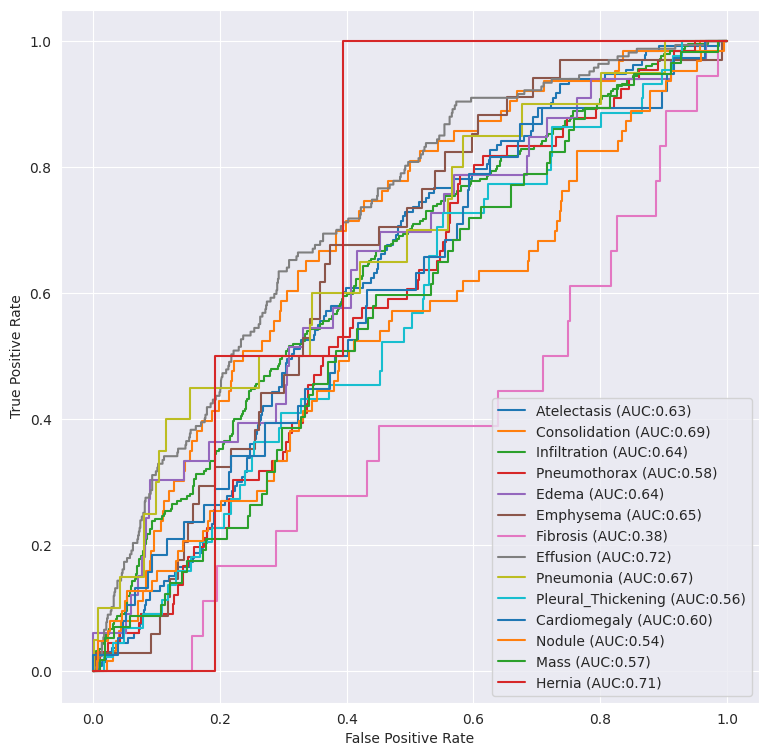

In [101]:
from sklearn.metrics import roc_curve, auc,f1_score
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
mean_auc_vgg19_process = 0
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), y_pred_vgg19_process[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    mean_auc_vgg19_process += auc(fpr, tpr)

mean_auc_vgg19_process /= 14
print(mean_auc_vgg19_process)
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')


## EfficientNetV2S 

In [102]:
input = tf.keras.layers.Input([IMAGE_SIZE, IMAGE_SIZE, 3], dtype = tf.float32)

eff = tf.keras.applications.EfficientNetV2S(include_top = False,weights = 'imagenet') 
eff = eff(input)

normal = BatchNormalization() (eff)
flatten = GlobalAveragePooling2D() (normal)

dense1 = Dense(256,activation = 'relu') (flatten)

output = Dense(len(all_labels), activation = 'sigmoid') (dense1)

eff_model = tf.keras.Model(inputs=[input], outputs=[output])
eff_model.summary()

82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 26s 0us/step


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-s (Functional)   │ (None, 4, 4, 1280)     │    20,331,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 4, 4, 1280)     │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 14)             │         3,598 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,668,014 (78.84 MB)

 Trainable params: 20,511,582 (78.25 MB)

 Non-trainable params: 156,432 (611.06 KB)

In [103]:
eff_model.compile(optimizer = tf.keras.optimizers.AdamW(0.0001), loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', tf.keras.metrics.AUC()])


In [104]:
steps_per_epoch = train_df.shape[0]  // BATCH_SIZE
steps_per_epoch


1000

In [105]:
# eff_model.fit(train_data, 
#             steps_per_epoch = steps_per_epoch,
# #           validation_data = valid_data, 
#             epochs = 1, 
#             verbose = 1,
#           )


### NORMAL

In [106]:
eff_model.load_weights("nih_data/weights/effv2s.h5")

In [107]:
y_pred_eff_normal = eff_model.predict(test_X_normal)
y_pred_eff_normal[:5]


32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 48ms/step


array([[0.12214409, 0.05478479, 0.2121055 , 0.1389123 , 0.04154311,
        0.06224166, 0.0177667 , 0.13385132, 0.02099066, 0.06673819,
        0.02548901, 0.07634922, 0.08621808, 0.00444543],
       [0.18399164, 0.1267126 , 0.2991    , 0.17278844, 0.06757549,
        0.05957649, 0.02316062, 0.34186697, 0.04597462, 0.10427958,
        0.05566225, 0.08832914, 0.12882386, 0.00770645],
       [0.15066583, 0.14751953, 0.4029993 , 0.14066522, 0.11111853,
        0.04501861, 0.00588667, 0.276225  , 0.04051187, 0.04861113,
        0.04427658, 0.04828223, 0.0819424 , 0.00150562],
       [0.21353848, 0.15818754, 0.40121284, 0.11204411, 0.11686048,
        0.03820654, 0.00563274, 0.3567787 , 0.05036295, 0.0486668 ,
        0.05180062, 0.04086184, 0.07728736, 0.00219423],
       [0.22530198, 0.16356182, 0.40289256, 0.11201019, 0.10828049,
        0.03164377, 0.00525052, 0.38892767, 0.04819283, 0.04717978,
        0.05075052, 0.03599313, 0.07480574, 0.00203058]], dtype=float32)

Mean AUC: 0.6340
Mean F1 Score: 0.1623


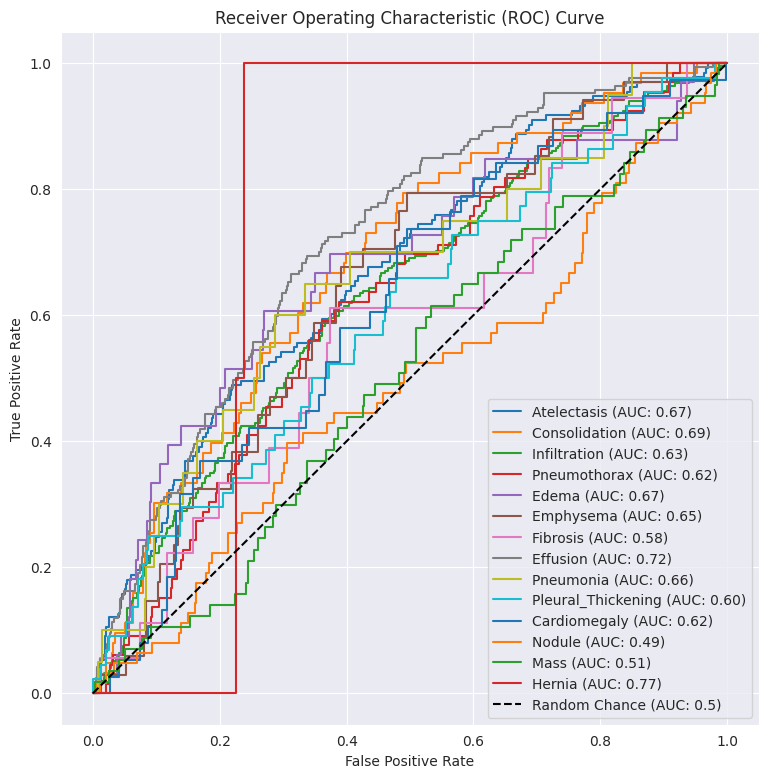

In [127]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, f1_score
import tensorflow as tf

# Assuming `y_pred_eff_normal` is the model's predictions and `test_Y` is the true labels

fig, c_ax = plt.subplots(1, 1, figsize=(9, 9))

mean_auc_eff_normal = 0
f1_eff_normal = 0

# Loop over all labels
for idx, c_label in enumerate(all_labels):
    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(test_Y[:, idx].astype(int), y_pred_eff_normal[:, idx])

    # Compute AUC for each class
    auc_score = auc(fpr, tpr)
    mean_auc_eff_normal += auc_score

    # Plot ROC curve for the current label
    c_ax.plot(fpr, tpr, label=f'{c_label} (AUC: {auc_score:.2f})')

    # Calculate F1 Score for the current label (using the best threshold)
    best_threshold_idx = np.argmax(tpr - fpr)  # You can use this or another method to select the best threshold
    predicted_labels = (y_pred_eff_normal[:, idx] > thresholds[best_threshold_idx]).astype(int)
    f1_eff_normal += f1_score(test_Y[:, idx].astype(int), predicted_labels)

# Calculate the mean AUC across all classes
mean_auc_eff_normal /= len(all_labels)

# Calculate the mean F1 score across all classes
f1_eff_normal /= len(all_labels)

# Print the mean AUC and mean F1 score
print(f'Mean AUC: {mean_auc_eff_normal:.4f}')
print(f'Mean F1 Score: {f1_eff_normal:.4f}')

# Add the random chance line (diagonal line at 0.5)
c_ax.plot([0, 1], [0, 1], 'k--', label='Random Chance (AUC: 0.5)')

# Set labels and title
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
c_ax.set_title('Receiver Operating Characteristic (ROC) Curve')

# Show the legend
c_ax.legend()

# Show the ROC plot
plt.show()


### PREPROCESS

In [109]:
eff_model.load_weights("nih_data/vgg19h5/effv2s_1.h5")

In [110]:
y_pred_eff_process = eff_model.predict(test_X_process)
y_pred_eff_process[:5]


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step


array([[1.90047666e-01, 7.29537532e-02, 2.41937220e-01, 3.72590013e-02,
        4.21920158e-02, 2.46915668e-02, 9.67765320e-03, 1.31028444e-01,
        3.25894915e-02, 2.79028434e-02, 1.98929440e-02, 6.43297955e-02,
        4.04192396e-02, 2.36683316e-03],
       [7.07512628e-03, 2.67153303e-03, 5.70988096e-02, 5.93761215e-03,
        3.19375889e-04, 2.98327114e-03, 1.53515907e-02, 3.53398360e-02,
        1.86539046e-03, 6.45378381e-02, 3.18829459e-03, 2.10369211e-02,
        1.69131923e-02, 3.30063340e-05],
       [2.37618119e-01, 1.25896320e-01, 3.72001499e-01, 4.72205095e-02,
        1.03658274e-01, 2.20342185e-02, 4.80570970e-03, 2.44714856e-01,
        5.04149608e-02, 3.13142464e-02, 2.70714127e-02, 5.60440794e-02,
        3.68528552e-02, 2.33489834e-03],
       [4.98336628e-02, 1.31911281e-02, 1.23348169e-01, 7.20496336e-03,
        4.81055165e-03, 6.21852744e-03, 7.30912760e-03, 1.68332942e-02,
        9.17748921e-03, 1.03312535e-02, 6.64849672e-03, 5.18935509e-02,
        1.934

Mean AUC: 0.6339905288257602
Mean F1 Score: 0.0013891317440889045


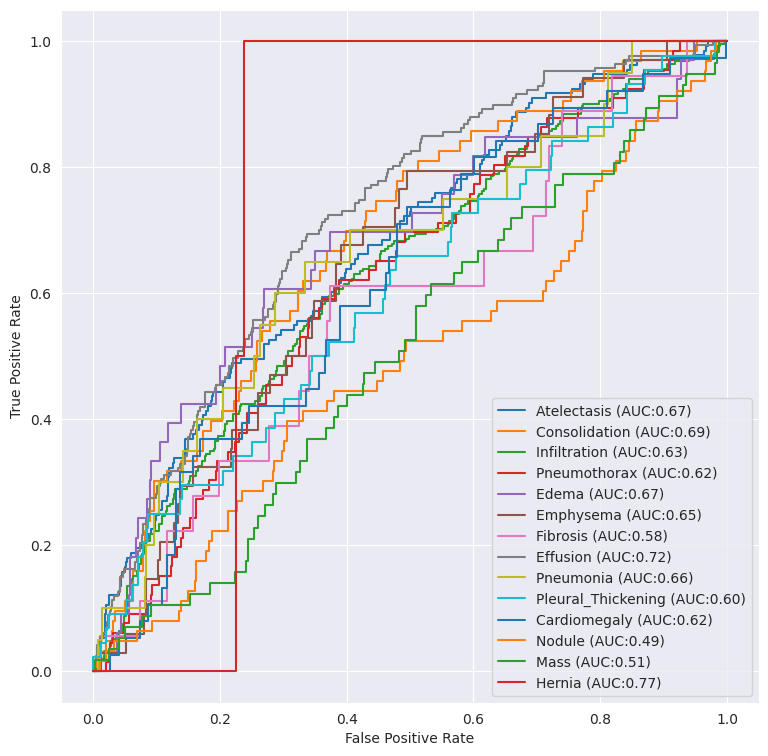

In [111]:
from sklearn.metrics import roc_curve, auc, f1_score
import matplotlib.pyplot as plt

fig, c_ax = plt.subplots(1, 1, figsize=(9, 9))
mean_auc_eff_normal = 0
f1_eff_normal = 0

for idx, c_label in enumerate(all_labels):
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(test_Y[:, idx].astype(int), y_pred_eff_normal[:, idx])
    # Calculate and plot AUC
    auc_value = auc(fpr, tpr)
    c_ax.plot(fpr, tpr, label='%s (AUC:%0.2f)' % (c_label, auc_value))
    mean_auc_eff_normal += auc_value
    # Calculate F1 score
    f1_eff_normal += f1_score(test_Y[:, idx].astype(int), (y_pred_eff_normal[:, idx] > 0.5).astype(int))

# Calculate mean AUC
mean_auc_eff_normal /= len(all_labels)

print(f"Mean AUC: {mean_auc_eff_normal}")
print(f"Mean F1 Score: {f1_eff_normal / len(all_labels)}")  # Print mean F1 score
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()


In [112]:
import h5py as h5py 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device
# Initialize a dictionary to store the counts
import torch.nn as nn
label_counts = {}
label_map={'Emphysema':0,
           'Effusion':1,
           'Nodule':2,
           'Pneumothorax':3,
           'Atelectasis':4,
           'Pleural_Thickening':5,
           'Mass':6,
           'Edema':7,
           'Consolidation':8,
           'Infiltration':9,
           'Fibrosis':10,
           'Pneumonia':11,
           'No Finding':12
          }
print("Length of labels are :",len(label_map))

# Iterate over the labels
for label in label_map.keys():
    # Count the number of times each label appears in the 'Finding Labels' column
    label_counts[label] = all_xray_df['Finding Labels'].str.contains(label).sum()

# Calculate class weights
total_count = sum(label_counts.values())
class_weights = {k: total_count/v for k, v in label_counts.items()}

# Convert class weights to tensor
# weights = [class_weights[i] for i in range(len(class_weights))]
# class_weights_tensor = torch.FloatTensor(weights).to(device)

# Convert class weights to tensor
weights = [class_weights[label] for label in label_map.keys()]
class_weights_tensor = torch.FloatTensor(weights).to(device)

# Define your criterion with the class weights
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor)

# Print the counts and class weights
for label, count in label_counts.items():
    print(f'Label {label}: {count} images, weight: {class_weights[label]}')
from torch.utils.data import Dataset
import pandas as pd
from PIL import Image
class NIH_Chest_Xray_Dataset(Dataset):
    def __init__(self, data_dir, df, label_map, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.df = df
        self.label_map = label_map

        for i, row in self.df.iterrows():
            img_name = row['Image Index']
            labels = row['Finding Labels'].split("|")
            # Only include the image if its label is in label_map
            if any(label in self.label_map for label in labels):
                for i in range(1, 13):
                    img_path = os.path.join(self.data_dir, f'images_{str(i).zfill(3)}/images/', img_name)
                    if os.path.isfile(img_path):
                        self.image_paths.append(img_path)
                        self.labels.append(labels)
                        break

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        labels = self.labels[idx]

        img = Image.open(img_path).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)

        num_labels = len(self.label_map)
        binary_label = torch.zeros(num_labels)

        for label in labels:
            if label in self.label_map:
                binary_label[self.label_map[label]] = 1

        return img, binary_label 


Length of labels are : 13
Label Emphysema: 1254 images, weight: 45.240829346092504
Label Effusion: 6861 images, weight: 8.268765486080746
Label Nodule: 2960 images, weight: 19.166216216216217
Label Pneumothorax: 2556 images, weight: 22.19561815336463
Label Atelectasis: 5628 images, weight: 10.080312722103766
Label Pleural_Thickening: 1747 images, weight: 32.47395535203206
Label Mass: 2852 images, weight: 19.892005610098177
Label Edema: 1204 images, weight: 47.119601328903656
Label Consolidation: 2436 images, weight: 23.288998357963877
Label Infiltration: 9122 images, weight: 6.219250164437623
Label Fibrosis: 801 images, weight: 70.82646691635456
Label Pneumonia: 777 images, weight: 73.014157014157
Label No Finding: 18534 images, weight: 3.060969029891011


In [121]:
from sklearn.model_selection import train_test_split
from torchvision import transforms
data_dir = 'nih_data/nih-chest-xrays/data/versions/3/'
df = pd.read_csv(os.path.join(data_dir, 'Data_Entry_2017.csv'))

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=10),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Split the DataFrame into a training set and a test set
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)

# Create the train and test datasets 
train_dataset = NIH_Chest_Xray_Dataset(data_dir, train_df, label_map, transform=transform)
test_dataset = NIH_Chest_Xray_Dataset(data_dir, test_df, label_map, transform=transform)

print('DF size (Total) ',len(df))
print('Train dataset size:', len(train_dataset))
print('Test dataset size:', len(test_dataset))

    

DF size (Total)  112120
Train dataset size: 99811
Test dataset size: 11104


In [114]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [115]:
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.models import vision_transformer

#model.head = torch.nn.Linear(out_features=14,in_features=768)  #14
# Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT 
#pretrained_vit_weights=torchvision.models.vit_l_16(pretrained=True)

# Setup a ViT model instance with pretrained weights
#model = torchvision.models.vit_l_16(weights=pretrained_vit_weights)
model = torchvision.models.vit_b_16(weights=pretrained_vit_weights)

# Freeze the base parameters
for parameter in model.parameters():
    parameter.requires_grad = False
    
# change your out_features according to number of classes defined, we have 14 classes 
#model.heads = nn.Linear(in_features=1024, out_features=13)
model.heads = nn.Linear(in_features=768, out_features=13)

model.to(device)  # to put the whole architecture to gpu memory
#print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 330M/330M [01:58<00:00, 2.93MB/s]


In [116]:
# import torch.nn as nn
# import torch.optim as optim
# from torchvision.models import vit_b_16
# from torchvision.models import vit_l_16

# # Setup a ViT model instance without pretrained weights
# model = vit_l_16(pretrained=False)

# # Freeze the base parameters
# for parameter in model.parameters():
#     parameter.requires_grad = False
    
# # Change your out_features according to number of classes defined, we have 14 classes 
# #model.heads = nn.Linear(in_features=768, out_features=13) #for vit_b_16
# model.heads = nn.Linear(in_features=1024, out_features=13) #for vit_l_16

# model.to(device)  # To put the whole architecture to GPU memory
# print(model)
# criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [117]:
from tqdm import tqdm

model.train()
num_epochs = 6

train_losses = []  # List to store training losses
train_accuracies = []  # List to store training accuracies

for epoch in range(num_epochs):
    running_loss = 0.0
    corrects = torch.zeros(13).to(device)  # change torch.zeros(No.classes) according to classes defined above
    total_samples = 0
    
    for images, labels in tqdm(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        
        # Calculate training accuracy
        predicted_labels = torch.sigmoid(outputs) > 0.5
        corrects += (predicted_labels == labels).sum(dim=0).float()
        total_samples += images.size(0)
    
    epoch_loss = running_loss / len(train_dataset)
    epoch_accuracy = corrects / total_samples
    
    # Print and save training loss and accuracy
    print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {}'.format(epoch+1, num_epochs, epoch_loss, epoch_accuracy.tolist()))
    
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy.tolist())


  0%|                                                                                                                                                      | 0/3120 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3120/3120 [1:00:35<00:00,  1.05it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3120/3120 [1:00:36<0

Epoch [1/6], Loss: 1.1942, Accuracy: [0.6768091320991516, 0.6797046065330505, 0.5086212754249573, 0.67323237657547, 0.582490861415863, 0.6214645504951477, 0.573794424533844, 0.7396579384803772, 0.6636542677879333, 0.49310195446014404, 0.5945436954498291, 0.622907280921936, 0.5700473785400391]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3120/3120 [1:00:21<00:00,  1.16s/it]


Epoch [2/6], Loss: 1.1733, Accuracy: [0.6987205743789673, 0.687930166721344, 0.5198625326156616, 0.6891725063323975, 0.589063286781311, 0.6362224221229553, 0.5898147225379944, 0.7526124119758606, 0.6663293242454529, 0.4990231394767761, 0.6124575138092041, 0.6393082737922668, 0.5724719762802124]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3120/3120 [1:01:24<00:00,  1.18s/it]


Epoch [3/6], Loss: 1.1713, Accuracy: [0.6977186799049377, 0.6880604028701782, 0.5217661261558533, 0.6927192211151123, 0.590125322341919, 0.6360421180725098, 0.5944133996963501, 0.7539950013160706, 0.6645459532737732, 0.49690914154052734, 0.6230775713920593, 0.6501287221908569, 0.5727124214172363]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3120/3120 [1:00:39<00:00,  1.17s/it]


Epoch [4/6], Loss: 1.1701, Accuracy: [0.7046117186546326, 0.6880003213882446, 0.531955361366272, 0.6906452775001526, 0.5919086933135986, 0.6329562664031982, 0.5939425230026245, 0.7537445425987244, 0.6657482385635376, 0.4972998797893524, 0.618659257888794, 0.6451392769813538, 0.5725821852684021]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3120/3120 [58:01<00:00,  1.12s/it]


Epoch [5/6], Loss: 1.1710, Accuracy: [0.7034595012664795, 0.6884511709213257, 0.5256233811378479, 0.6902345418930054, 0.5902255177497864, 0.6386870741844177, 0.5984410047531128, 0.7555780410766602, 0.6675115823745728, 0.4938233196735382, 0.6149121522903442, 0.6305516958236694, 0.5711995363235474]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3120/3120 [1:05:19<00:00,  1.26s/it]


Epoch [6/6], Loss: 1.1698, Accuracy: [0.7038402557373047, 0.686377227306366, 0.523880124092102, 0.691567063331604, 0.5915780663490295, 0.6352405548095703, 0.6000440716743469, 0.7530232071876526, 0.6627725958824158, 0.499383807182312, 0.6172966957092285, 0.6487060189247131, 0.572131335735321]


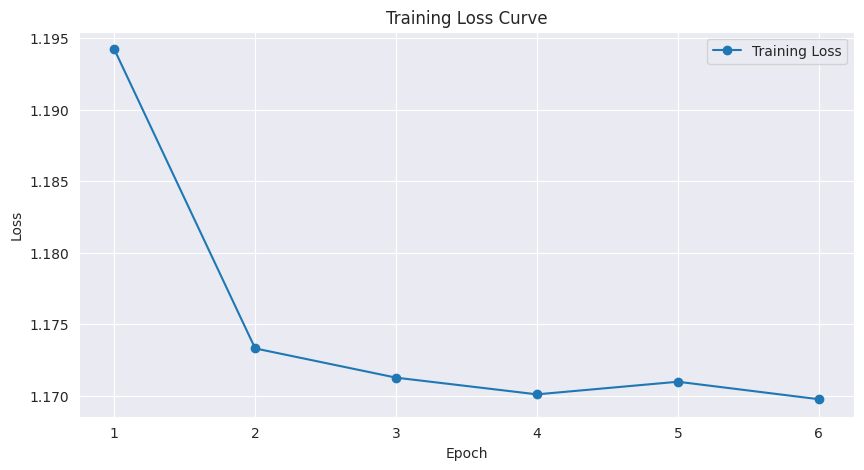

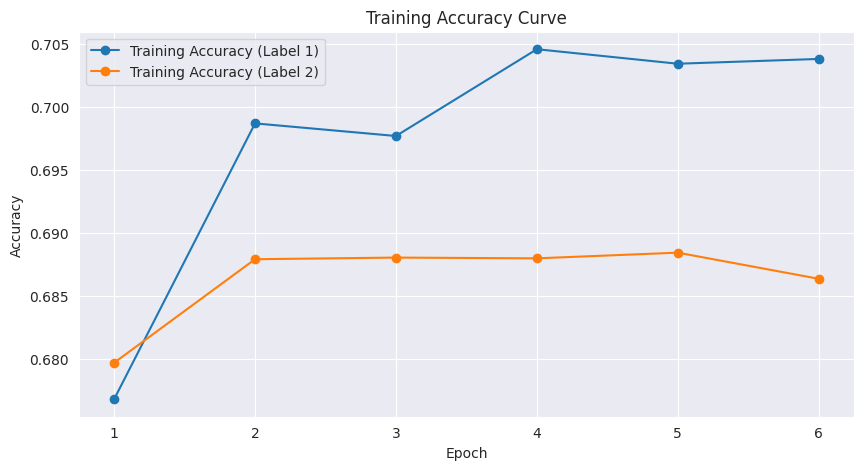

In [123]:
import matplotlib.pyplot as plt

# Plot training loss curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, marker='o', label='Training Loss')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training accuracy curve
plt.figure(figsize=(10, 5))
for i in range(2):  # Plot accuracy for each label
    plt.plot(range(1, num_epochs+1), [acc[i] for acc in train_accuracies], marker='o', label=f'Training Accuracy (Label {i+1})')

plt.title('Training Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [124]:
torch.save(model.state_dict(), 'nih_data/xray14_tranformer_weights/transformer_weights.pth')

In [125]:
#Evaluate
from sklearn.metrics import roc_auc_score,roc_curve
import matplotlib.pyplot as plt

model.eval()
auc_scores = []    
running_loss = 0.0
running_corrects = torch.zeros(13).to(device)
total_samples = 0
num_labels = 13  # change lables here
with torch.no_grad():
    y_true = []
    y_pred = []
    for inputs, labels in tqdm(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * inputs.size(0)
        predicted_labels = torch.sigmoid(outputs) > 0.5
        predicted_probs = torch.sigmoid(outputs)
                
        running_corrects += (predicted_labels == labels).sum(dim=0).float()
        total_samples += inputs.size(0)
        y_pred.append(predicted_probs.cpu().numpy())
        y_true.append(labels.cpu().numpy())

epoch_loss = running_loss / total_samples
epoch_acc = running_corrects / total_samples
y_pred = np.concatenate(y_pred)
y_true = np.concatenate(y_true)
fpr, tpr, thresholds = roc_curve(y_true.ravel(), y_pred.ravel())
auc_score = roc_auc_score(y_true, y_pred, average='macro')

#auc_score = roc_auc_score(y_true, y_pred, multi_class='ovr') 
print(f'Validation Loss: {epoch_loss:.4f} | Validation Acc: {epoch_acc.tolist()} | AUC score: {auc_score:.4f}')

  0%|                                                                                                                                                       | 0/347 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 347/347 [05:42<00:00,  1.03it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 347/347 [05:42<0

Validation Loss: 1.1654 | Validation Acc: [0.7343299388885498, 0.733519434928894, 0.4854106605052948, 0.6950648427009583, 0.4155259132385254, 0.4500179886817932, 0.7092939019203186, 0.8876981139183044, 0.7105547189712524, 0.4823486804962158, 0.5926693081855774, 0.29764047265052795, 0.5751981139183044] | AUC score: 0.7427


  0%|                                                                                                                                                       | 0/347 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 347/347 [06:06<00:00,  1.05s/it]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 347/347 [06:06<0

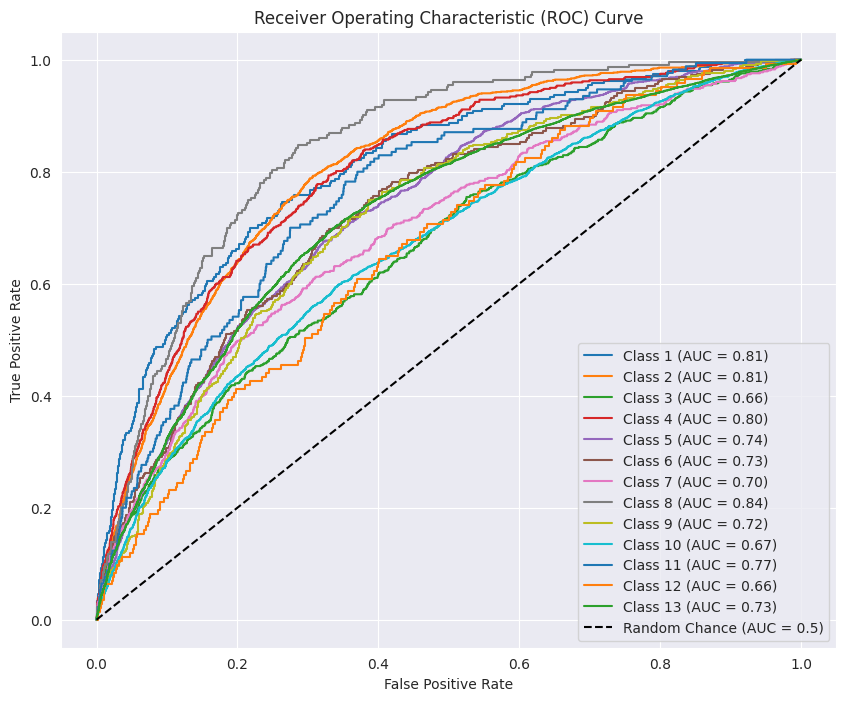

Class 1 AUC Score: 0.8099
Class 2 AUC Score: 0.8079
Class 3 AUC Score: 0.6629
Class 4 AUC Score: 0.8013
Class 5 AUC Score: 0.7364
Class 6 AUC Score: 0.7323
Class 7 AUC Score: 0.6965
Class 8 AUC Score: 0.8404
Class 9 AUC Score: 0.7226
Class 10 AUC Score: 0.6700
Class 11 AUC Score: 0.7655
Class 12 AUC Score: 0.6634
Class 13 AUC Score: 0.7288
Average AUC Score: 0.7414


In [126]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

# Evaluate the model
model.eval()
auc_scores = []    
running_loss = 0.0
running_corrects = torch.zeros(13).to(device)  # Number of labels/classes
total_samples = 0
num_labels = 13  # change labels if necessary

y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in tqdm(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * inputs.size(0)
        
        predicted_probs = torch.sigmoid(outputs)  # Get predicted probabilities
        predicted_labels = predicted_probs > 0.5  # Thresholding to get class labels (binary classification)

        # Update running corrects for accuracy calculation
        running_corrects += (predicted_labels == labels).sum(dim=0).float()
        total_samples += inputs.size(0)
        
        # Collect predictions and true labels for AUC calculation
        y_pred.append(predicted_probs.cpu().numpy())
        y_true.append(labels.cpu().numpy())

# Calculate average loss and accuracy
epoch_loss = running_loss / total_samples
epoch_acc = running_corrects / total_samples

# Concatenate predictions and true labels for all batches
y_pred = np.concatenate(y_pred)
y_true = np.concatenate(y_true)

# Plot the ROC curve for each class
plt.figure(figsize=(10, 8))
fpr = {}
tpr = {}
roc_auc = {}

# Loop over each label and compute the ROC curve
for i in range(num_labels):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])  # ROC curve for each class
    roc_auc[i] = roc_auc_score(y_true[:, i], y_pred[:, i])  # AUC score for each class
    plt.plot(fpr[i], tpr[i], label=f'Class {i+1} (AUC = {roc_auc[i]:.2f})')

# Plot the random chance line
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance (AUC = 0.5)')

# Set plot labels and title
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

# Show the plot
plt.show()

# Print AUC scores for each class
for i in range(num_labels):
    print(f'Class {i+1} AUC Score: {roc_auc[i]:.4f}')

# Print average AUC score across all classes
average_auc = np.mean(list(roc_auc.values()))
print(f'Average AUC Score: {average_auc:.4f}')
